In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table,Column,MaskedColumn,QTable
from astropy.cosmology import FlatLambdaCDM
import scipy.constants as C
from astropy.coordinates import SkyCoord
from astropy import units as u
import xgboost as xgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
import sklearn.model_selection
import optuna
import shutil

mpl.rcParams.update({'font.size': 20})
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['axes.linewidth']=2
font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        }

# Version of Python Package

In [2]:
print('Numpy',np.__version__)
print('Pandas',pd.__version__)
print('XGBoost',xgb.__version__)
print('Optuna',optuna.__version__)
print('Scikit-learn',sklearn.__version__)

Numpy 1.21.5
Pandas 1.5.1
XGBoost 1.7.1
Optuna 3.0.3
Scikit-learn 1.0.2


# Read the Selected Quasars

In [2]:
data=ascii.read('./predqso_all_pvalues_secure_specz.csv')

# Input Features

In [3]:
all_para=pd.DataFrame(
    {
        "fuv_nuv":pd.Series(data['fuv_nuv'],dtype='float'),
        "nuv_u":pd.Series(data['nuv_u'],dtype='float'),
        "nuv_g":pd.Series(data['nuv_g'],dtype='float'),
        "u_g":pd.Series(data['u_g'],dtype='float'),
        "g_r":pd.Series(data['g_r'],dtype='float'),
        "r_i":pd.Series(data['r_i'],dtype='float'),
        "i_z":pd.Series(data['i_z'],dtype='float'),
        "z_y":pd.Series(data['z_y'],dtype='float'),
        "y_J":pd.Series(data['y_J'],dtype='float'),
        "J_H":pd.Series(data['J_H'],dtype='float'),
        "H_K":pd.Series(data['H_K'],dtype='float'),
        "K_3p6":pd.Series(data['K_3p6'],dtype='float'),
        "y_3p6":pd.Series(data['y_3p6'],dtype='float'),
        "i_3p6":pd.Series(data['i_3p6'],dtype='float'),
        "r_3p6":pd.Series(data['r_3p6'],dtype='float'),
        "z_3p6":pd.Series(data['z_3p6'],dtype='float'),
        "g_3p6":pd.Series(data['g_3p6'],dtype='float'),
        "ir3p6_4p5":pd.Series(data['ir3p6_4p5'],dtype='float'),
    }
)
all_para=all_para.round(3)


#regressor
training_sdss=np.where((data['train_test_flag']==1)&\
                    ((data['z_spec_s']=='SDSS')))
training_secure=np.where((data['train_test_flag']==1)&\
                    ((data['z_spec_s']!='SDSS')&(data['z_spec_s']!='0')))

print('N of training sample SDSS quasars:',np.size(training_sdss))
print('N of training sample secure-specz quasars:',np.size(training_secure))

training=np.where((data['train_test_flag']==1)&\
                    ((data['z_spec_s']!='0')))
print('N of training sample quasars:',np.size(training))


all_training_para=pd.DataFrame(
    {
        "fuv_nuv":pd.Series(data['fuv_nuv'][training],dtype='float'),
        "nuv_u":pd.Series(data['nuv_u'][training],dtype='float'),
        "nuv_g":pd.Series(data['nuv_g'][training],dtype='float'),
        "u_g":pd.Series(data['u_g'][training],dtype='float'),
        "g_r":pd.Series(data['g_r'][training],dtype='float'),
        "r_i":pd.Series(data['r_i'][training],dtype='float'),
        "i_z":pd.Series(data['i_z'][training],dtype='float'),
        "z_y":pd.Series(data['z_y'][training],dtype='float'),
        "y_J":pd.Series(data['y_J'][training],dtype='float'),
        "J_H":pd.Series(data['J_H'][training],dtype='float'),
        "H_K":pd.Series(data['H_K'][training],dtype='float'),
        "K_3p6":pd.Series(data['K_3p6'][training],dtype='float'),
        "y_3p6":pd.Series(data['y_3p6'][training],dtype='float'),
        "i_3p6":pd.Series(data['i_3p6'][training],dtype='float'),
        "r_3p6":pd.Series(data['r_3p6'][training],dtype='float'),
        "z_3p6":pd.Series(data['z_3p6'][training],dtype='float'),
        "g_3p6":pd.Series(data['g_3p6'][training],dtype='float'),
        "ir3p6_4p5":pd.Series(data['ir3p6_4p5'][training],dtype='float'),
    }
)
all_training_para=all_training_para.round(3)
#(1+z) is the true physical parameter
red_shift=1
all_training_zspec=data['z_spec'][training]+red_shift
print('Redshift range of training sample',\
      np.around(np.min(all_training_zspec-red_shift),decimals=3),\
      np.around(np.max(all_training_zspec-red_shift),decimals=3),\
      '\nMedian redshift of training sample',\
      np.around(np.median(all_training_zspec-red_shift),decimals=3))

test=np.where((data['train_test_flag']==0)&\
                    ((data['z_spec_s']!='0')))
print('N of blind-test sample quasars:',np.size(test))

all_test_para=pd.DataFrame(
    {
        "fuv_nuv":pd.Series(data['fuv_nuv'][test],dtype='float'),
        "nuv_u":pd.Series(data['nuv_u'][test],dtype='float'),
        "nuv_g":pd.Series(data['nuv_g'][test],dtype='float'),
        "u_g":pd.Series(data['u_g'][test],dtype='float'),
        "g_r":pd.Series(data['g_r'][test],dtype='float'),
        "r_i":pd.Series(data['r_i'][test],dtype='float'),
        "i_z":pd.Series(data['i_z'][test],dtype='float'),
        "z_y":pd.Series(data['z_y'][test],dtype='float'),
        "y_J":pd.Series(data['y_J'][test],dtype='float'),
        "J_H":pd.Series(data['J_H'][test],dtype='float'),
        "H_K":pd.Series(data['H_K'][test],dtype='float'),
        "K_3p6":pd.Series(data['K_3p6'][test],dtype='float'),
        "y_3p6":pd.Series(data['y_3p6'][test],dtype='float'),
        "i_3p6":pd.Series(data['i_3p6'][test],dtype='float'),
        "r_3p6":pd.Series(data['r_3p6'][test],dtype='float'),
        "z_3p6":pd.Series(data['z_3p6'][test],dtype='float'),
        "g_3p6":pd.Series(data['g_3p6'][test],dtype='float'),
        "ir3p6_4p5":pd.Series(data['ir3p6_4p5'][test],dtype='float'),
    }
)
all_test_para=all_test_para.round(3)
all_test_zspec=data['z_spec'][test]+red_shift

test_gs=np.where((data['train_test_flag']==0)&\
                    ((data['z_spec_s']!='0')&(data['CFHT_u']!=999)))
print('N of blind-test sample quasars with CFHT u* !=999:',np.size(test_gs))

all_test_para_gs=pd.DataFrame(
    {
        "fuv_nuv":pd.Series(data['fuv_nuv'][test_gs],dtype='float'),
        "nuv_u":pd.Series(data['nuv_u'][test_gs],dtype='float'),
        "nuv_g":pd.Series(data['nuv_g'][test_gs],dtype='float'),
        "u_g":pd.Series(data['u_g'][test_gs],dtype='float'),
        "g_r":pd.Series(data['g_r'][test_gs],dtype='float'),
        "r_i":pd.Series(data['r_i'][test_gs],dtype='float'),
        "i_z":pd.Series(data['i_z'][test_gs],dtype='float'),
        "z_y":pd.Series(data['z_y'][test_gs],dtype='float'),
        "y_J":pd.Series(data['y_J'][test_gs],dtype='float'),
        "J_H":pd.Series(data['J_H'][test_gs],dtype='float'),
        "H_K":pd.Series(data['H_K'][test_gs],dtype='float'),
        "K_3p6":pd.Series(data['K_3p6'][test_gs],dtype='float'),
        "y_3p6":pd.Series(data['y_3p6'][test_gs],dtype='float'),
        "i_3p6":pd.Series(data['i_3p6'][test_gs],dtype='float'),
        "r_3p6":pd.Series(data['r_3p6'][test_gs],dtype='float'),
        "z_3p6":pd.Series(data['z_3p6'][test_gs],dtype='float'),
        "g_3p6":pd.Series(data['g_3p6'][test_gs],dtype='float'),
        "ir3p6_4p5":pd.Series(data['ir3p6_4p5'][test_gs],dtype='float'),
    }
)
all_test_para_gs=all_test_para_gs.round(3)
all_test_zspec_gs=data['z_spec'][test_gs]+red_shift

N of training sample SDSS quasars: 651
N of training sample secure-specz quasars: 71
N of training sample quasars: 722
Redshift range of training sample 0.127 3.86 
Median redshift of training sample 1.574
N of blind-test sample quasars: 361
N of blind-test sample quasars with CFHT u* !=999: 211


# Using Optuna to Find Optimal Hyperparameters for the Regressor

In [ ]:
def objective(trial):
    param={ "booster":"gbtree",
            "tree_method":"hist",
            'objective':"reg:squarederror",
            "missing":999.000,
            "colsample_bytree":1,
            "subsample":1,
            "seed":0,
            "n_estimators":100,
            "grow_policy":trial.suggest_categorical("grow_policy", ["depthwise"]),
            "reg_lambda":trial.suggest_float("reg_lambda",0.1,10.0,step=0.1),
            "reg_alpha":trial.suggest_float("reg_alpha",0.0,5.0,step=0.1),
            "max_depth":trial.suggest_int("max_depth",5,10),
            "learning_rate":trial.suggest_categorical("learning_rate",[0.1,0.2,0.3]),
            "gamma":trial.suggest_categorical("gamma",[0.1,0.2,0.3]),
            "min_child_weight":trial.suggest_int("min_child_weight",1,10,step=1),
            "max_delta_step":trial.suggest_int("max_delta_step",1,10)
            }

    regressor_obj=xgb.XGBRegressor(**param,use_label_encoder=False)
    reds_pred=sklearn.model_selection.cross_val_predict(regressor_obj,\
                                                        all_training_para,\
                                                        all_training_zspec,cv=5)
    mse=sklearn.metrics.mean_squared_error(reds_pred-red_shift,all_training_zspec-red_shift)
    return mse

if __name__ == "__main__":
    for i in range(1):
        study_step3=optuna.create_study(direction="minimize")
        study_step3.optimize(objective,n_trials=5000)
        plot_optimization_history(study_step3)
        f=open('step3_best_param.txt',"a+")
        f.write("Best trial:")
        btrial=study_step3.best_trial
        f.write("  Value: {}".format(btrial.value)+"\n")
        
        param_step3={"booster":"gbtree",
                     "tree_method":"hist",
                     'objective':'reg:squarederror',
                     "grow_policy":study_step3.best_trial.params['grow_policy'],
                     "missing":999.000,
                     "n_estimators":100,
                     "reg_lambda":np.around(study_step3.best_trial.params['reg_lambda'],decimals=2),
                     "reg_alpha":np.around(study_step3.best_trial.params['reg_alpha'],decimals=2),
                     "max_depth":study_step3.best_trial.params['max_depth'],
                     "learning_rate":np.around(study_step3.best_trial.params['learning_rate'],decimals=2),
                     "gamma":np.around(study_step3.best_trial.params['gamma'],decimals=2),
                     "min_child_weight":np.around(study_step3.best_trial.params['min_child_weight'],decimals=1),
                     "colsample_bytree":1,
                     "subsample":1,
                     "max_delta_step":study_step3.best_trial.params['max_delta_step']
                    }
           
        f.write(str(param_step3)+'\n')
        f.close()

# Five-fold Cross-validation and Blind Test

MSE of five-fold cross-validation: 0.134


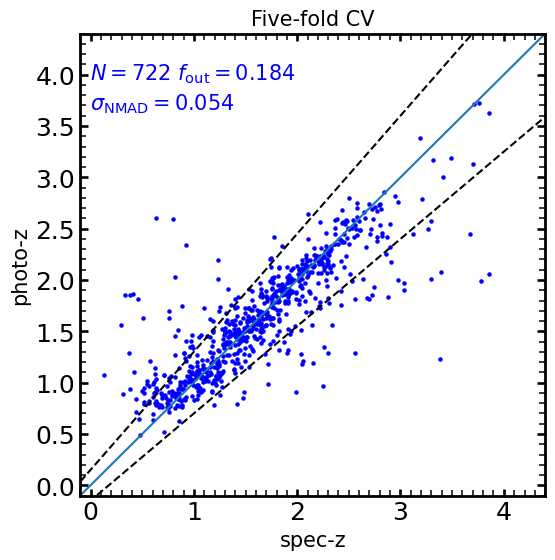

Blind test result:
MSE: 0.149
Fraction of outlier photo-z: 0.227
sigma_nmad 0.079
____________
For CFHT u*!=999 sources
MSE: 0.112
Fraction of outlier photo-z: 0.171
sigma_nmad 0.074


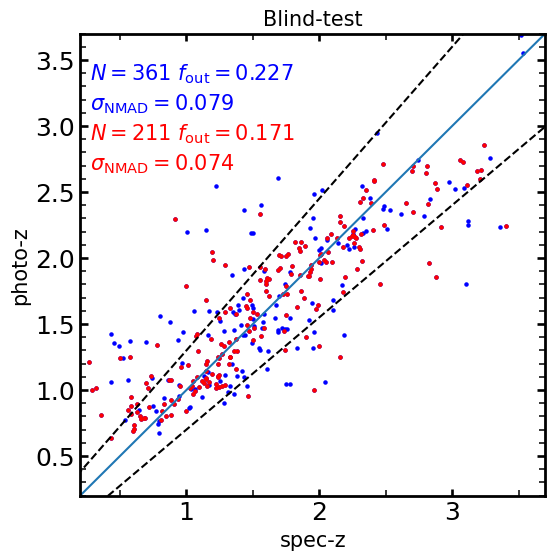

In [58]:
param_step3={'booster': 'gbtree', 'tree_method': 'hist', 'objective': 'reg:squarederror', 'grow_policy': 'depthwise', 'missing': 999.0, 'n_estimators': 100, 'reg_lambda': 0.9, 'reg_alpha': 0.2, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.1, 'min_child_weight': 2, 'colsample_bytree': 1, 'subsample': 1, 'max_delta_step': 3}

regre_allz=xgb.XGBRegressor(**param_step3)
reds_pred=sklearn.model_selection.cross_val_predict(regre_allz,\
                                                    all_training_para,\
                                                    all_training_zspec,cv=5)
mse=sklearn.metrics.mean_squared_error(reds_pred,all_training_zspec)
print('MSE of five-fold cross-validation:',np.around(mse,decimals=3))

detlta_z_train=(reds_pred-all_training_zspec)/(1+all_training_zspec-red_shift)
good_photoz=np.where(abs(detlta_z_train)<=0.15)
outlier_photoz=np.where(abs(detlta_z_train)>0.15)
fout=np.around(np.size(outlier_photoz)/np.size(all_training_zspec),decimals=3)
nmad=np.around(1.48*np.median(np.abs(all_training_zspec[good_photoz]-reds_pred[good_photoz]-\
                           np.median(all_training_zspec[good_photoz]-reds_pred[good_photoz]))/(1+all_training_zspec[good_photoz]-red_shift)),decimals=3)


#five-fold cross validation
fig, axs=plt.subplots(figsize=(6,6))
xx=np.array([-0.1,4.9])
yy=np.array([-0.1,4.9])
yy1=0.15*(1+xx)+xx
yy2=-0.15*(1+xx)+xx
axs.scatter(all_training_zspec-red_shift,reds_pred-red_shift,s=5,color='blue')
axs.plot(xx,yy)
axs.plot(xx,yy1,linestyle='--',color='black')
axs.plot(xx,yy2,linestyle='--',color='black')
axs.annotate(r'$N=$'+str(np.size(all_training_zspec))+r' $f_{\rm out}=$'+str(fout),fontsize=15,\
             xy=(0.15,0.8),xycoords='figure fraction',color='blue')
axs.annotate(r'$\sigma_{\rm NMAD}=$'+str(nmad),fontsize=15,\
             xy=(0.15,0.75),xycoords='figure fraction',color='blue')
axs.set_xlabel("spec-z",size=15)
axs.set_ylabel("photo-z",size=15)
axs.set_title('Five-fold CV',size=15)
axs.set_xlim(-0.1,4.4)
axs.set_ylim(-0.1,4.4)
ax=plt.gca()
yminorLocator = mpl.ticker.MultipleLocator(0.1)
xminorLocator = mpl.ticker.MultipleLocator(0.1)
axs.tick_params('y',direction='in',which='major',right=True,width=1.9,length=6,labelsize=18.)
axs.tick_params('y',direction='in',which='minor',right=True,width=1.1,length=4,labelsize=18.)
axs.tick_params('x',direction='in',which='major',top=True,width=1.9,length=5,labelsize=18.)
axs.tick_params('x',direction='in',which='minor',top=True,width=1.1,length=4,labelsize=18.)
ax.yaxis.set_minor_locator(yminorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
plt.show()

print('Blind test result:')
# blind test
regre_allz.fit(all_training_para,\
               all_training_zspec)

pred_reds=regre_allz.predict(all_test_para)
actu_reds=all_test_zspec

mse=sklearn.metrics.mean_squared_error(pred_reds,actu_reds)
print('MSE:',np.around(mse,decimals=3))
detlta_z=(actu_reds-pred_reds)/(1+actu_reds-red_shift)
good_photoz=np.where(abs(detlta_z)<=0.15)
outlier_photoz=np.where(abs(detlta_z)>=0.15)
nmad=np.around(1.48*np.median(np.abs(actu_reds[good_photoz]-pred_reds[good_photoz]-\
                           np.median(actu_reds[good_photoz]-pred_reds[good_photoz]))/(1+actu_reds[good_photoz]-red_shift)),decimals=3)
print('Fraction of outlier photo-z:',np.around(np.size(outlier_photoz)/np.size(actu_reds),decimals=3))
print('sigma_nmad',np.around(nmad,decimals=3))

print('____________')
print('For CFHT u*!=999 sources')
pred_reds_gs=regre_allz.predict(all_test_para_gs)
actu_reds_gs=all_test_zspec_gs

mse_gs=sklearn.metrics.mean_squared_error(pred_reds_gs,actu_reds_gs)
print('MSE:',np.around(mse_gs,decimals=3))

detlta_z_gs=(actu_reds_gs-pred_reds_gs)/(1+actu_reds_gs-red_shift)
good_photoz_gs=np.where(abs(detlta_z_gs)<=0.15)
outlier_photoz_gs=np.where(abs(detlta_z_gs)>=0.15)
nmad_gs=np.around(1.48*np.median(np.abs(actu_reds_gs[good_photoz_gs]-pred_reds_gs[good_photoz_gs]-\
                           np.median(actu_reds_gs[good_photoz_gs]-pred_reds_gs[good_photoz_gs]))/(1+actu_reds_gs[good_photoz_gs]-red_shift)),decimals=3)
print('Fraction of outlier photo-z:',np.around(np.size(outlier_photoz_gs)/np.size(actu_reds_gs),decimals=3))
print('sigma_nmad',np.around(nmad_gs,decimals=3))

fout=np.around(np.size(outlier_photoz)/np.size(actu_reds),decimals=3)
fout_gs=np.around(np.size(outlier_photoz_gs)/np.size(actu_reds_gs),decimals=3)

fig, axs=plt.subplots(figsize=(6,6))
xx=np.array([-0.1,5.5])
yy=np.array([-0.1,5.5])
yy1=0.15*(1+xx)+xx
yy2=-0.15*(1+xx)+xx
axs.scatter(actu_reds-red_shift,pred_reds-red_shift,s=5,color='blue')
axs.scatter(actu_reds_gs-red_shift,pred_reds_gs-red_shift,s=5,color='red')
axs.plot(xx,yy)
axs.plot(xx,yy1,linestyle='--',color='black')
axs.plot(xx,yy2,linestyle='--',color='black')
axs.annotate(r'$N=$'+str(np.size(test))+r' $f_{\rm out}=$'+str(fout),fontsize=15,\
             xy=(0.15,0.8),xycoords='figure fraction',color='blue')
axs.annotate(r'$\sigma_{\rm NMAD}=$'+str(nmad),fontsize=15,\
             xy=(0.15,0.75),xycoords='figure fraction',color='blue')
axs.annotate(r'$N=$'+str(np.size(test_gs))+r' $f_{\rm out}=$'+str(fout_gs),fontsize=15,\
             xy=(0.15,0.7),xycoords='figure fraction',color='red')
axs.annotate(r'$\sigma_{\rm NMAD}=$'+str(nmad_gs),fontsize=15,\
             xy=(0.15,0.65),xycoords='figure fraction',color='red')
axs.set_xlabel("spec-z",size=15)
axs.set_ylabel("photo-z",size=15)
axs.set_title("Blind-test",size=15)
axs.set_xlim(0.2,3.7)
axs.set_ylim(0.2,3.7)

ax=plt.gca()
yminorLocator = mpl.ticker.MultipleLocator(0.1)
xminorLocator = mpl.ticker.MultipleLocator(0.5)
axs.tick_params('y',direction='in',which='major',right=True,width=1.9,length=6,labelsize=18.)
axs.tick_params('y',direction='in',which='minor',right=True,width=1.1,length=4,labelsize=18.)
axs.tick_params('x',direction='in',which='major',top=True,width=1.9,length=5,labelsize=18.)
axs.tick_params('x',direction='in',which='minor',top=True,width=1.1,length=4,labelsize=18.)
ax.yaxis.set_minor_locator(yminorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
plt.show()

# Predict Photo-zs for Quasars in the XMM-LSS Field

In [62]:
#all photo-zs predicted 
pred_reds_all=regre_allz.predict(all_para)

xmmlss=np.where(data['train_test_flag']==1)
print('Range of photo-zs for the 1591 quasars in the XMM-LSS field:',\
      np.around(np.min(pred_reds_all[xmmlss])-1,decimals=2),\
      np.around(np.max(pred_reds_all[xmmlss])-1,decimals=2),\
      '\nMedian:',np.around(np.median(pred_reds_all[xmmlss])-1,decimals=2))

#generatet the photo-z file of all predicted quasars
data_output=QTable([data['ra_parent'][xmmlss],\
             data['dec_parent'][xmmlss],\
             pred_reds_all[xmmlss]-1],\
            names=['ra_parent',\
                   'dec_parent',\
                   'z_photo'])
ascii.write(data_output,'./predqso_xmmlss_zphoto.csv',format='csv',overwrite=True)


Range of photo-zs for the 1591 quasars in the XMM-LSS field: 0.41 3.75 
Median: 1.62
